<a href="https://colab.research.google.com/github/HarrisonSantiago/energy-based-learning/blob/main/Copy_of_Testing_EBL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Energy Based Learning Demo

Energy Based Learning is an application of statistical mechanics for learning from data. Available compute is a barrier for a sizable portion of the population, this notebook demonstrates how to reproduce the results from the following papers in a Google Colab environment.

- [Energy-based learning algorithms for analog computing: a comparative study](https://proceedings.neurips.cc/paper_files/paper/2023/hash/a52b0d191b619477cc798d544f4f0e4b-Abstract-Conference.html)

- [A fast algorithm to simulate nonlinear resistive networks](https://arxiv.org/abs/2402.11674)

Additionally, it shows how to use this repo as a starting point for developing your own model. We assume some familiarity with energy based methods, but none with this repository.

To start, let's clone the repo and export our path. Google Colab handles environments a little different than you would locally, so we change how we export the path compared to the pre-reqs in the repo.

In [1]:
!git clone https://github.com/rain-neuromorphics/energy-based-learning
%cd /content/energy-based-learning
import os
os.environ['PYTHONPATH'] = f"/content/energy-based-learning:{os.environ.get('PYTHONPATH', '')}"

Cloning into 'energy-based-learning'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 112 (delta 44), reused 94 (delta 32), pack-reused 0 (from 0)
Receiving objects: 100% (112/112), 73.50 KiB | 6.68 MiB/s, done.
Resolving deltas: 100% (44/44), done.
/content/energy-based-learning


Make sure that you check for GPU/TPU availability and enable it. For some of the cells it is the difference between 3-5 minutes, or 90+.

In [2]:
import sys
import torch
if 'google.colab' in sys.modules and not torch.cuda.is_available():
    print("Warning: Using Colab but not in a GPU session")

# Click Below to load some functions used for visualizations in this notebook

In [3]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

def show_dataset_examples(loader, num_examples=4):
    # Get a batch from the loader
    dataiter = iter(loader)
    images, labels = next(dataiter)

    # Create a figure to display the images
    fig, axes = plt.subplots(1, num_examples, figsize=(5, 2))
    fig.suptitle("Dataset Examples")

    for i in range(num_examples):
        # Get the image and label
        img = images[i]
        label = labels[i].item()

        # Convert image from tensor to numpy array
        img = img.numpy().transpose((1, 2, 0))

        # Display the image
        axes[i].imshow(img, cmap = 'gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


def visualize_and_infer(_network, _energy_minimizer, _loader, num_samples=4):

    # Get a batch from the loader, test loader also provides index
    dataiter = iter(_loader)
    images, labels, idx = next(dataiter)

    # Select a subset of images
    images = images[:num_samples]
    labels = labels[:num_samples]

    _network.set_input(images, reset = True)
    _energy_minimizer.compute_equilibrium()

    # Get the output
    output = network._function.layers()[-1].state

    # Get predictions
    _, predicted = torch.max(output, 1)

    # Create a grid of images
    img_grid = make_grid(images, nrow=num_samples, normalize=True, padding=2)

    # Convert to numpy and transpose
    img_grid = img_grid.cpu().numpy().transpose((1, 2, 0))

    # Create a figure to display the images
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.imshow(img_grid, cmap="gray")
    ax.axis('off')

    # Add labels and predictions as text
    for i in range(num_samples):
        true_label = labels[i].item()
        pred_label = predicted[i].item()
        ax.text(i * (images.size(3) + 2) + images.size(3) / 2,
                images.size(2) + 10,
                f'True: {true_label}\nPred: {pred_label}',
                ha='center', va='top')

    plt.title("Dataset Examples with True Labels and Predictions")
    plt.tight_layout()
    plt.show()

#How to run the paper examples

This section is just to show how you can run the python scripts for generating the paper results, and how you can interact with the resulting artifacts. All in all it's pretty straightforward, just note that the artifacts will appear in the paper's directory.

In [ ]:
!python papers/fast-drn/drn.py --model='drn-xs' --algorithm='EP'

In [5]:
%load_ext tensorboard

In [ ]:
# When loading this in colab I need to zoom out to see the visualization
# It takes ~30 seconds for it to load after the cell stops running
%tensorboard --logdir '/content/energy-based-learning/papers/fast-drn/drn-xs/EP'

Here is how you can access all of the statistics saved during training

In [ ]:
import pickle
from IPython.display import HTML

#for formatting
display(HTML('''
<style>
  pre {
      white-space: normal;
  }
</style>
'''))

time_series = pickle.load(open('/content/energy-based-learning/papers/fast-drn/drn-xs/EP/time_series.pkl', 'rb'))

print(time_series.keys())


---

# How to create your own EQ-Prop model.

This section will walk you through how to uitilize the classes in this repo when creating an EBL model. The goal is to show how different parts of theory match to certain steps and classes.

Any hyperparamters in here were arbitrarilly chosen. I found some that worked, but didn't do any optimization beyond "does it get decent results"
***

The first step in any machine learning problem is to figure out what data you have, and what task you're trying to accomplish. For this example we'll be using the MNIST dataset, and trying to classify the digits. "Datasets" provides a way to load a variety of commonly used datasets into pytorch dataloaders (with a note that the test_loader is indexed).

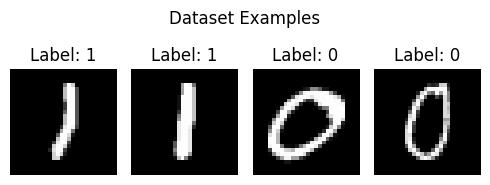

In [9]:
from datasets import load_dataloaders

dataset = 'MNIST'
batch_size = 512
training_loader, test_loader = load_dataloaders(dataset, batch_size, augment_32x32=False, normalize=False)

show_dataset_examples(training_loader)

Now let's start to get into the real work

**The Theory**

In Energy Based Learning (EBL), a model is composed of an input variable ($x$), a parameter variable ($\theta$), a hidden variable ($h$), and an output variable ($o$). The energy function, $E$, assigns to each tuple ($\theta$, $x$, $h$, $o$) a real number $E(\theta, x, h, o)$. The goal of training an EBL model is to adjust $\theta$ so that for any input $x$, the output $o(\theta, x)$ coincides with a desired output $y$.

The energy function $E(\theta, x, h, o)$ defines how these components interact. During inference, for a given input $x$ and current parameters $\theta$, the network will settle into a state that minimizes this energy, determining the values of $h$ and $o$. The learning process involves adjusting $\theta$ to shape the energy landscape so that desired input-output mappings correspond to low-energy states of the system.

If we let $\theta = (\theta_1, ..., \theta_N)$, for each $\theta_k$ we can denote $\{x, h\}_k$ as the information which is locally available to $\theta_k$. From here, we can define an energy function to be <i>sum-seperable</i> if it is of the form

$$
E = E_0 + \sum_{k} E_k(\theta_k, \{x,h\}k)
$$

where $E_0$ is a term that is independent of the parameters, and $E_k$ is a scalar function for each $k$.

**The Application**

For this example, we're using a 28x28 Deep Convolutional Hopfield network, similar to the one defined in Equation 18 in [Energy-based learning algorithms for analog computing: a comparative study](https://proceedings.neurips.cc/paper_files/paper/2023/hash/a52b0d191b619477cc798d544f4f0e4b-Abstract-Conference.html). If you look inside model.hopfield.network, you'll see that the model structure is as follows:

- Input layer ($x$): shape (num_input_filters, 28, 28)
- First hidden layer ($h_1$): shape (num_hidden_1, 12, 12)
- Second hidden layer ($h_2$): shape (num_hidden_2, 4, 4)
- Output layer ($o$): shape (num_output_units,)

In this context:

- $x$ corresponds to the input layer
- $\theta$ represents the energy function's parameters, including convolutional filter weights and biases for each layer
-$h$ encompasses both hidden layers ($h = {h_1, h_2}$), representing the internal state of the network
-$o$ corresponds to the output layer

When creating an energy function, the general steps are as follows:
- Create Layers with weights and biases (model.variable.layer or your own)
- Create interactions between layers
- Use the above to create multiple SumSeperableFunction Classes (model.function.interactions)

Then you can take this energy function, and use it to make a Network. **The Network class is one of convenience and not theoretical importance. For any energy function, is provides a unified way to set the input and get a list of the free layers**

In [10]:
from model.hopfield.network import ConvHopfieldEnergy28
from model.function.network import Network
from model.function.cost import SquaredError

# Build the network: a convolutional Hopfield network (DCHN) with 28x28-pixel input images
energy_fn = ConvHopfieldEnergy28(num_outputs = 10)

# Set the device on which we run and train the network
device = "cuda" if torch.cuda.is_available() else "cpu"

energy_fn.set_device(device)
network = Network(energy_fn)

Since we will be using equilibrium propagation, we use the squared error cost function. Like any cost function it needs our output, $o(x, \theta, h)$, so we enter the output layer upon initialization (alternatively, you could do network._function.layers()[-1]).

In [11]:
output_layer = energy_fn.layers()[-1]
cost_fn = SquaredError(output_layer)

**The theory**

Let's remember that Energy Based Learning comes in two phases:

 - In the Relaxed Phase (or "free phase" or "clamped phase"), the system is allowed to settle into a stable state based on the input data alone. This equilibrium state represents the network's prediction or output for the given input

- In the Perturbed Phase, the system is slightly nudged towards the desired output. This is accomplished by adding a small perturbation to the energy function, based on the difference between the current output and the target output. Following this, the system is allowed to settle into a new equilibrium state under this perturbed energy landscape.

**The application**

For the Relaxed Phase we use our previously defined Energy Function, as it is purely defined by the input and the internal states. Next, we have to figure out how to create our "nudged" energy function. The AugmentedFunction class is wrapper for doing this using your Relaxed Phase function and your cost function.



In [12]:
from training.sgd import AugmentedFunction

#Define the energy function for the perturbed phase
augmented_fn = AugmentedFunction(energy_fn, cost_fn)


Both the energy function and the augmented function are instances of SumSeperableFunctions. The core idea is that we use a gradient-based approach to minimize these functions with respect to each layer of the network.

Under-the-hood, you need to create updaters for every layer. Then the minimizer class found in minimizer.minimizer uses there to compute equilibrium trajectories.  


In [13]:
from model.hopfield.minimizer import FixedPointMinimizer

#Define Model Params
num_iterations_inference = 30
num_iterations_training = 5

# Define the energy minimizer used in the perturbed phase
free_layers = network.free_layers()
energy_minimizer_perturbed = FixedPointMinimizer(augmented_fn, free_layers)
energy_minimizer_perturbed.num_iterations = num_iterations_training

#Define the energy minimizer used at inference
energy_minimizer_inference = FixedPointMinimizer(energy_fn, free_layers)
energy_minimizer_inference.num_iterations = num_iterations_inference

Now in order to minimize the augmented function, we need a way to solve

$$ \text{minimize} \quad C(h(\theta)) \\
\text{subject to} \quad h(\theta) = \arg\min_h E(\theta, h) $$

where $C(\cdot)$ is a cost function. To do this, we leverage the GradientEstimator Class (training.sgd), which let us estimate the gradient of $C(h(\theta))$ with respect to $\theta$.

In general, we need to expose a few key things to these Gradient Estimator Classes:
- The parameters whose gradients we want to estimate
- The layers that minimize the augmented energy function
- The algorithm we want to use to minimize the augmented energy function

In [14]:
from training.sgd import EquilibriumProp
#Define the gradient estimator: centered equilibrium propagation (CEP)
params = energy_fn.params()
layers = energy_fn.layers()
nudging = 0.15


estimator = EquilibriumProp(params, layers, augmented_fn, cost_fn, energy_minimizer_perturbed)
estimator.nudging = nudging
estimator.variant = 'centered'

Next we build our Optimizer, is a class of convience that implements a "custom" SGD Optimizer. The main idea is that it makes it easier to match parameters to learning rates.

In [15]:
from training.monitor import Optimizer
# Define Model Params
learning_rates_weights = [0.02, 0.02, 0.2, 0.2]
learning_rates_biases = [0.02, 0.02, 0.02, 0.02]
momentum = 0.9
weight_decay = 3 * 1e-4

# Build the optimizer (SGD)
learning_rates = learning_rates_biases + learning_rates_weights
optimizer = Optimizer(energy_fn, cost_fn, learning_rates, momentum, weight_decay)

At this point we have our energy function, cost function, dataloaders, gradient estimators, optimizers, and energy minimizers. We're finally ready to do some training!

Monitor, Trainer, and Evaluator are classes you can use to organize your training.

From a high level, Trainer trains the network on data, and the Evaluator evaluates after each training epoch. The Monitor is a class that calls each once an epoch, and tracks various training statistics. I recommend quickly reading training.monitor and training.epoch, they're pretty straightfoward and it shouldn't take longer than a minute or two.

In [17]:
from training.monitor import Monitor
from training.epoch import Trainer, Evaluator

#Define Model Params
num_epochs = 2

trainer = Trainer(network, cost_fn, training_loader, estimator, optimizer, energy_minimizer_inference)
evaluator = Evaluator(network, cost_fn, test_loader, energy_minimizer_inference)

# Define the scheduler for the learning rates
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

# Define the path to save results to, and the monitor to perform the run
path = os.getcwd() + '/Example'
monitor = Monitor(energy_fn, cost_fn, trainer, scheduler, evaluator, path)


Now let's finally train our network!

In [19]:

# Print the characteristics of the run
print('Dataset: {} -- batch_size={}'.format(dataset, batch_size))
print('Network: ', energy_fn)
print('Cost function: ', cost_fn)
print('Energy minimizer during inference: ', energy_minimizer_inference)
print('Energy minimizer during training: ', energy_minimizer_perturbed)
print('Gradient estimator: ', estimator)
print('Parameter optimizer: ', optimizer)
print('Number of epochs = {}'.format(num_epochs))
print('Path = {}'.format(path))
print('Device = {}'.format(device))
print()

# Launch the experiment
monitor.run(num_epochs, verbose=True)

Dataset: MNIST -- batch_size=512
Network:  ConvHopfieldEnergy28 -- size=[1, 32, 64, 10], activation=hard-sigmoid, pooling=conv_max_pool, gains=[0.6, 0.6, 1.5]
Cost function:  Squared Error (MSE)
Energy minimizer during inference:  Fixed point minimizer -- mode=asynchronous, num_iterations=30
Energy minimizer during training:  Fixed point minimizer -- mode=asynchronous, num_iterations=5
Gradient estimator:  Equilibrium propagation -- mode=centered, nudging=0.15, formula=standard
Parameter optimizer:  SGD -- initial learning rates = [0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.2, 0.2], momentum=0.9, weight_decay=0.00030000000000000003
Number of epochs = 2
Path = /content/energy-based-learning/Example
Device = cuda

Epoch 1
TRAIN -- Example 60000/60000, Energy = -198.08, Cost = 0.21523, Error = 20.435%, Top5Error = 4.632%
TEST  -- Example 10000/10000, Energy = -231.86, Cost = 0.10432, Error = 5.700%, Top5Error = 0.310%
Duration = 0 hours 1 min 3 sec 

Epoch 2
TRAIN -- Example 60000/60000, Energ

And let's see how well it does on a few examples!

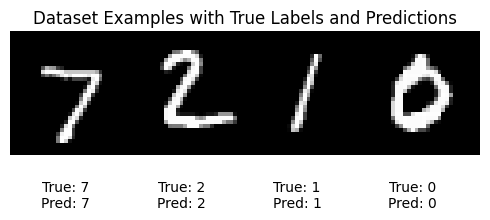

In [20]:
visualize_and_infer(network, energy_minimizer_inference, test_loader)

At this point you should be able to follow along with any of the paper scripts. I recomment looking at the DRN one, follow along, and start diving into the code at places you don't understand. Try to keep in mind that the "meat and potatoes" of the functionality tends to be wrapped in a class or two that standardize how you can interact with everything.